In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# 读取数据集
data = pd.read_csv("/root/2023mcm/new_data.csv")

# 准备数据集
X = data.iloc[:, [1,12, 13, 14, 15, 16, 18, 19,20]].values
y = data.iloc[:, 5:12].values

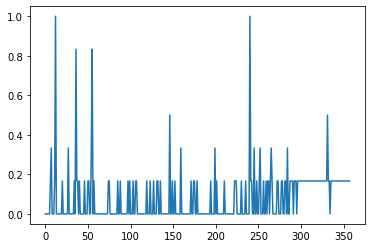

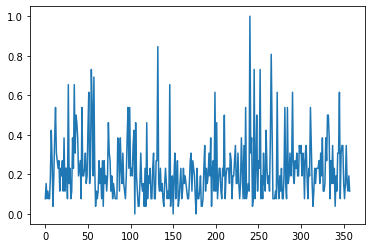

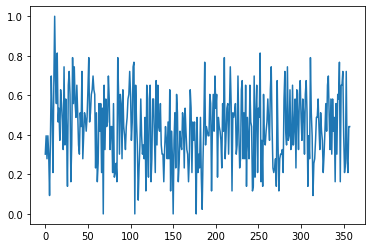

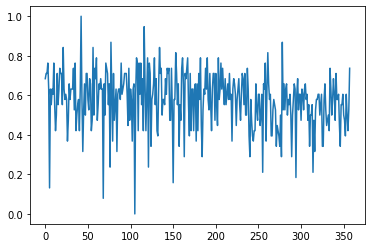

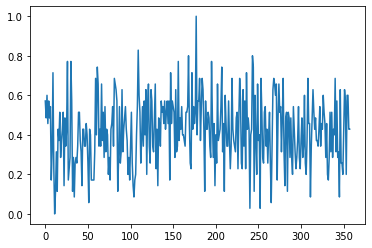

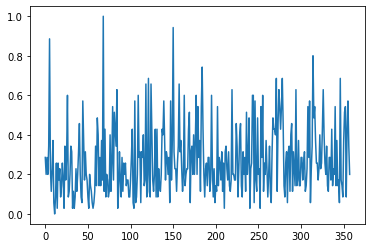

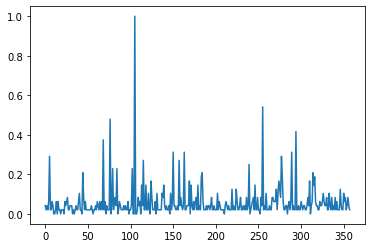

In [2]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y=scaler.fit_transform(y)
for i in range(7):
    plt.plot(y[:,i])
    plt.show()

Epoch 1000/20000, Train Loss: 0.0211, Test Loss: 0.0185
Epoch 2000/20000, Train Loss: 0.0193, Test Loss: 0.0175
Epoch 3000/20000, Train Loss: 0.0191, Test Loss: 0.0173
Epoch 4000/20000, Train Loss: 0.0185, Test Loss: 0.0179
Epoch 5000/20000, Train Loss: 0.0177, Test Loss: 0.0225
Epoch 6000/20000, Train Loss: 0.0176, Test Loss: 0.0307
Epoch 7000/20000, Train Loss: 0.0170, Test Loss: 0.0377
Epoch 8000/20000, Train Loss: 0.0164, Test Loss: 0.0429
Epoch 9000/20000, Train Loss: 0.0158, Test Loss: 0.0477
Epoch 10000/20000, Train Loss: 0.0157, Test Loss: 0.0532
Epoch 11000/20000, Train Loss: 0.0151, Test Loss: 0.0584
Epoch 12000/20000, Train Loss: 0.0150, Test Loss: 0.0632
Epoch 13000/20000, Train Loss: 0.0146, Test Loss: 0.0694
Epoch 14000/20000, Train Loss: 0.0142, Test Loss: 0.0734
Epoch 15000/20000, Train Loss: 0.0141, Test Loss: 0.0787
Epoch 16000/20000, Train Loss: 0.0139, Test Loss: 0.0843
Epoch 17000/20000, Train Loss: 0.0135, Test Loss: 0.0892
Epoch 18000/20000, Train Loss: 0.0135, T

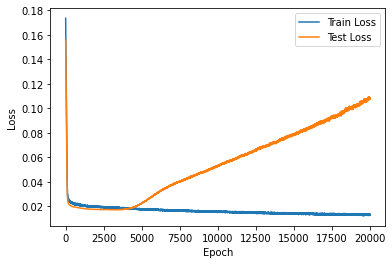

In [3]:
# 划分训练集和测试集
split_ratio = 0.7
split_index = int(len(data) * split_ratio)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# 将数据转换为张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM 网络模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout_rate=0.2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout=nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(len(x), 1, -1) 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out=self.dropout(out)
        out = self.fc(out)
        return out

# 训练函数
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        # 训练模型
        model.train()
        total_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 计算训练集和测试集上的损失
        train_loss.append(total_loss / len(train_loader))
        with torch.no_grad():
            model.eval()
            test_loss.append(get_loss(model, criterion, test_loader))

        # 打印损失
        if (epoch+1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}")

    return train_loss, test_loss
def get_loss(model, criterion, dataloader):
    total_loss = 0
    total_count = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        total_loss += loss.item() * X.size(0)
        total_count += X.size(0)
    return total_loss / total_count

# 设置超参数
input_size = 9
hidden_size = 64
num_layers = 1
output_size = 7
num_epochs =20000
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、损失函数和优化器
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from torch.utils.data import DataLoader, TensorDataset

# 将数据转换为 Dataset 对象
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# 创建 DataLoader 对象，指定批次大小
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 训练模型
train_loss, test_loss = train(model, criterion, optimizer, train_loader, test_loader, num_epochs)


#可视化训练过程中的损失值
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

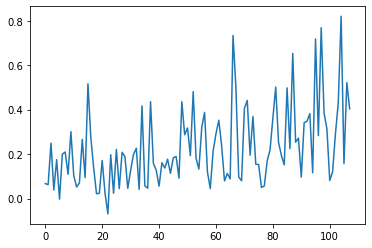

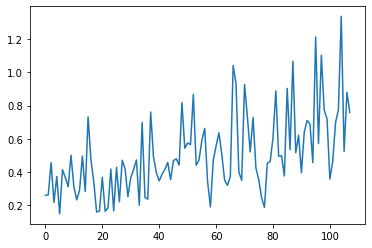

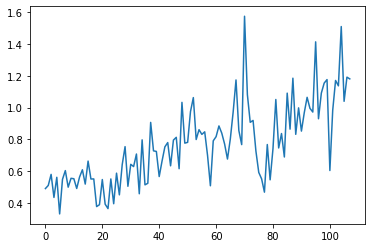

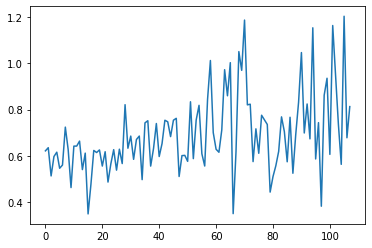

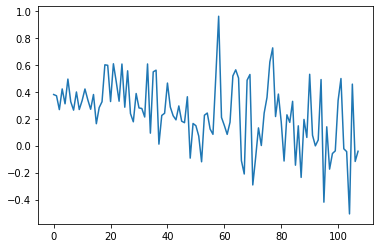

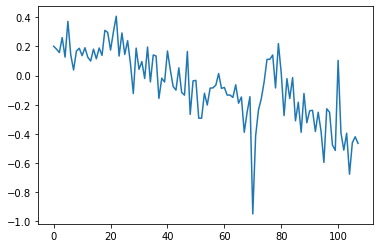

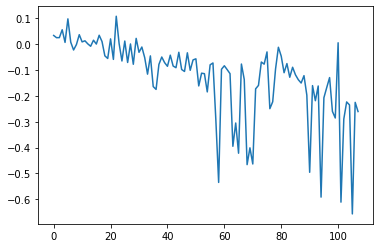

In [4]:
# 将测试集输入到模型中，得到预测值
y_pred = model(X_test.to(device)).detach().cpu().numpy()
np.shape(y_pred),np.shape(y_test)
for i in range(7):
    plt.plot(y_pred[:,i])
    plt.show()

Dimension 1: MSE = 0.03395999644532231, RMSE = 0.1842823823519826, MAE = 0.1316670405988892
Dimension 2: MSE = 0.12335281977569573, RMSE = 0.3512162009015184, MAE = 0.2838388649677789
Dimension 3: MSE = 0.17722551098712871, RMSE = 0.4209816040958663, MAE = 0.35180722970377515
Dimension 4: MSE = 0.062115595509908625, RMSE = 0.2492300052359439, MAE = 0.17734886912835968
Dimension 5: MSE = 0.08332554185973856, RMSE = 0.288661639051223, MAE = 0.22687652350092927
Dimension 6: MSE = 0.21544101162436585, RMSE = 0.4641562362226386, MAE = 0.3876852172219919
Dimension 7: MSE = 0.0628959775359492, RMSE = 0.2507907046442296, MAE = 0.19289230965767745


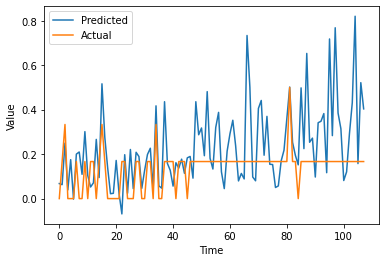

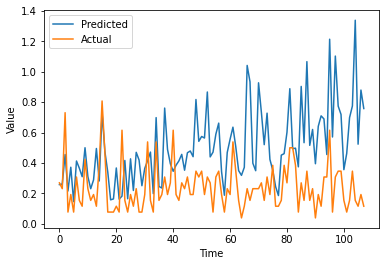

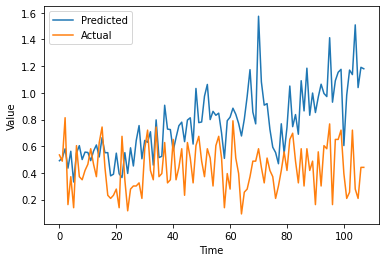

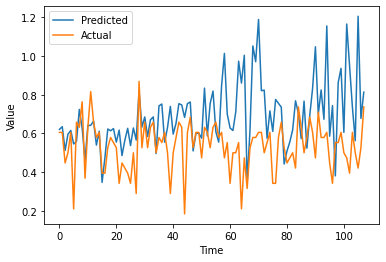

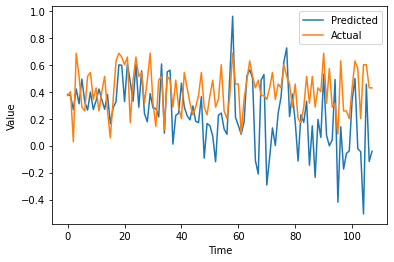

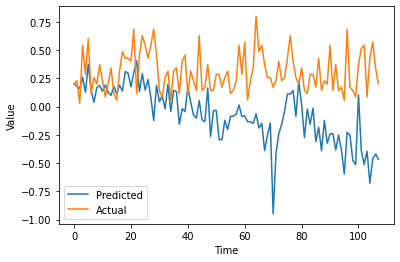

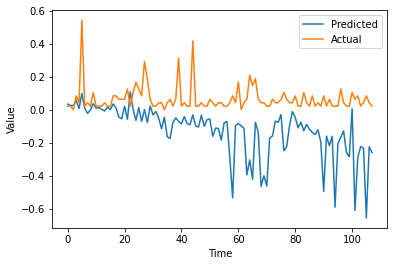

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler.fit(y)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
# 计算每个维度的 MSE、RMSE 和 MAE
for i in range(7):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    print("Dimension {}: MSE = {}, RMSE = {}, MAE = {}".format(i+1, mse, rmse, mae))
# 将每个维度的预测值和实际值都分别可视化
for i in range(7):
    plt.plot(y_pred[:, i], label="Predicted")
    plt.plot(y_test[:, i], label="Actual")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [6]:
import stats
#对于给定的输入 X，进行预测
X_new = np.array([[620,0, 1, 0, 3, 1, 1, 1,0.09318]]) # 举例子
scaler.fit(X_new)
X_new = scaler.transform(X_new) # 归一化
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
model.eval() # 模型评估模式
with torch.no_grad():
    y_pred = model(X_new_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
    print("预测值为：", y_pred)

预测值为： [[ 0.2227835   0.5773748   0.9862387   0.9389864   0.12053305 -0.32464984
  -0.26576644]]


In [7]:
from scipy import stats

def get_confidence_interval(model, X, alpha=0.05):
    """
    给定模型和输入，计算预测值和置信区间
    :param model: 已训练的模型
    :param X: 输入，形状为 (n_samples, n_features)
    :param alpha: 置信水平，默认为 0.05
    :return: 预测值、置信区间下界、置信区间上界
    """
    model.eval() # 模型评估模式
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device) # 转换为张量并放到 GPU 上（如果有）
        y_pred = model(X_tensor).cpu().numpy() # 将预测值转换为 numpy 数组
        n_samples = len(X)
        df = n_samples - model.hidden_size - 1 # 自由度
        se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
        t = stats.t.ppf(1 - alpha/2, df) # t 分布的分位数
        lower = y_pred - t * se # 置信区间下界
        upper = y_pred + t * se # 置信区间上界
    return y_pred, lower, upper

y_pred, lower, upper = get_confidence_interval(model, X_new)
print("预测值为：", y_pred)
print("置信区间为：[{}, {}]".format(lower, upper))

预测值为： [[ 0.2227835   0.5773748   0.9862387   0.9389864   0.12053305 -0.32464984
  -0.26576644]]
置信区间为：[[[nan nan nan nan nan nan nan]], [[nan nan nan nan nan nan nan]]]


/tmp/ipykernel_4714/212596868.py:17: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.sum((model(X_tensor).cpu().numpy() - y)**2) / df) # 标准误差
